In [40]:
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY
%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

# 개요

* U-net 기반으로 이미지 세그멘테이션 과제 수행
  * https://www.tensorflow.org/tutorials/images/segmentation?hl=ko

##  데이터 확보

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-train.tfrecord...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-test.tfrecord...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /home/hoondori/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [70]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1  #  original: [1,2,3] => [0, 1, 2]
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    # resize
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    
    # 절반 정도는 LR flip 한다. 
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    # 정규화
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

@tf.function
def load_image_test(datapoint):
    # resize
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
            
    # 정규화
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [19]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test) 

In [22]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test.batch(BATCH_SIZE)
train_dataset

<RepeatDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

### 이미지와 마스크 출력

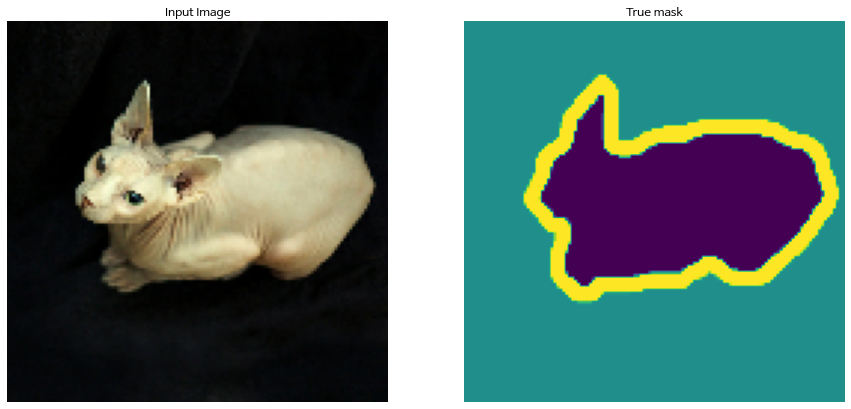

In [43]:
def display(display_list):
    
    # 그림 크기
    plt.figure(figsize=(15,15))
    
    # 타이들
    title = ['Input Image', 'True mask', 'Predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(      
            tf.keras.preprocessing.image.array_to_img(display_list[i])
        )
        plt.axis('off')
    plt.show()

for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])
    

## U-net 모델 정의 

* 인코더는 모바일넷v2
  * 중간 출력을 따서 skip connection
* 디코더는 pix2pix의 업샘플 블록 

In [44]:
# 인코더
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 중간 출력 for skip connection
layer_names = [
    'block_1_expand_relu', # 64 x 64
    'block_3_expand_relu', # 32 x 32
    'block_6_expand_relu', # 16 x 16
    'block_13_expand_relu', # 8 x 8
    'block_16_project'      # 4 x 4
]

layers = [base_model.get_layer(layer_name).output for layer_name in layer_names]

# downsampling stack
down_stack = tf.keras.Model(inputs=base_model.input,outputs=layers)
down_stack.trainable = False

In [45]:
# 업셈플러
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [73]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,3])
    
    # x 는 모델 빌딩시에 제일 끝점 추적점
    x = inputs
    
    # 다운샘플링
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # 건너뛰기를 업셈플링에 연결
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    # 마지막 층
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same') # 64 x 64 -> 128 * 128
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(output_channels=3)  # 출력은 각 픽셀당 segment class 3개 중 하나를 예측 (one-hot)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

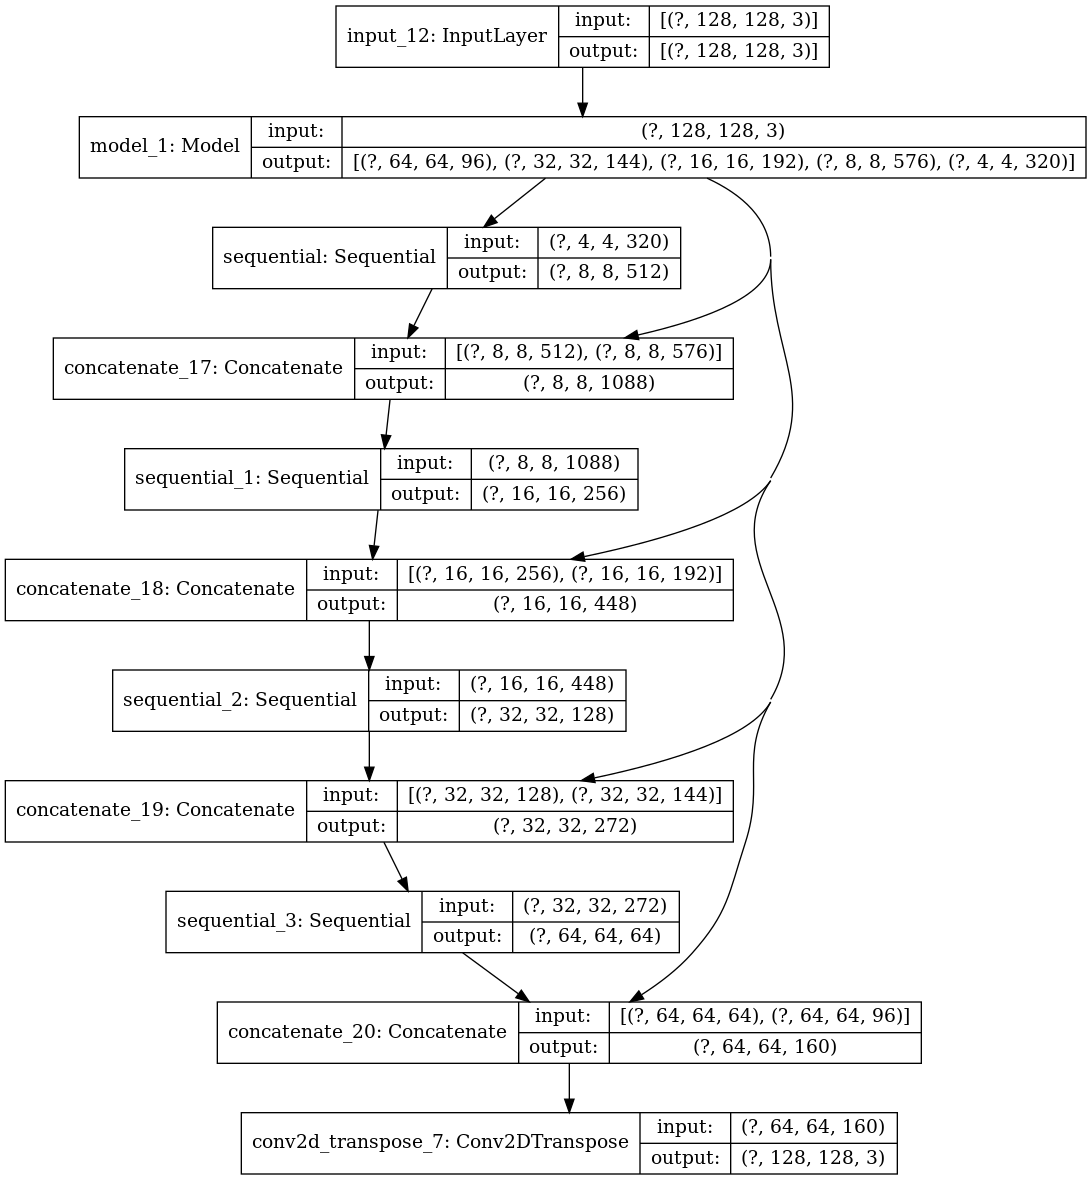

In [74]:
tf.keras.utils.plot_model(model, show_shapes=True)

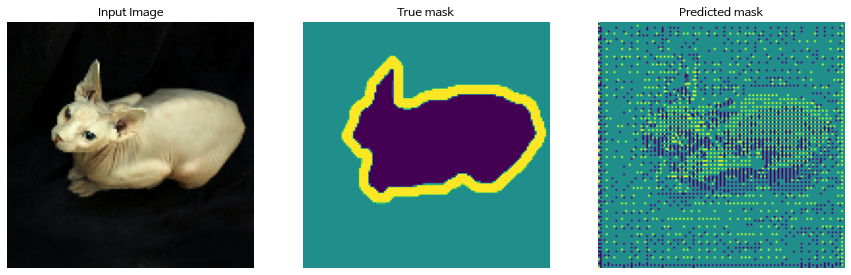

In [75]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()         

### 훈련 및 샘플의 예측 과정 향상 시각화

In [76]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))
        
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS        

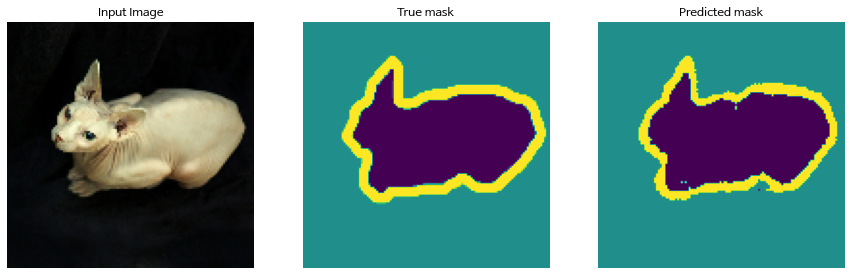


에포크 이후 예측 예시 5

57/57 [==============================] - 42s 739ms/step - loss: 0.2216 - accuracy: 0.9054 - val_loss: 0.2762 - val_accuracy: 0.8888


In [77]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()])

# 예측하기

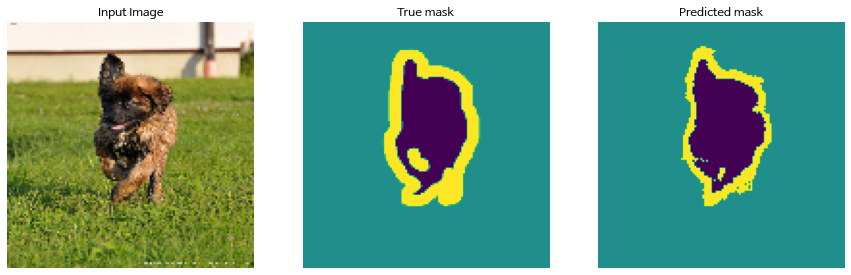

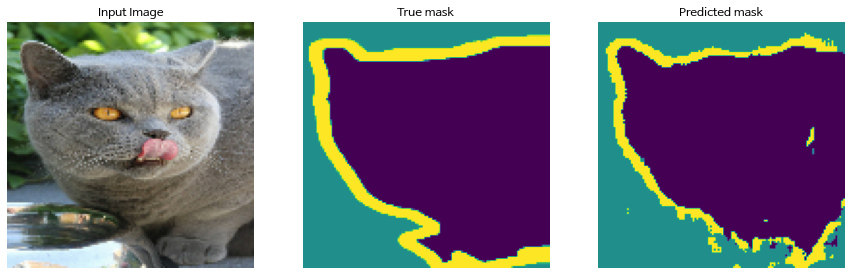

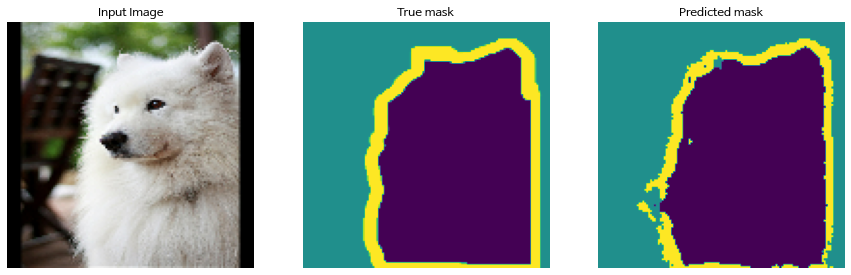

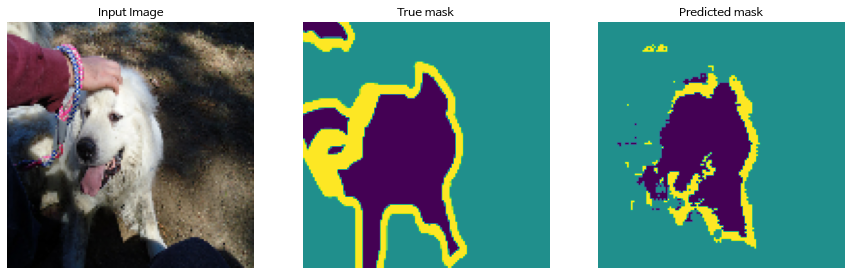

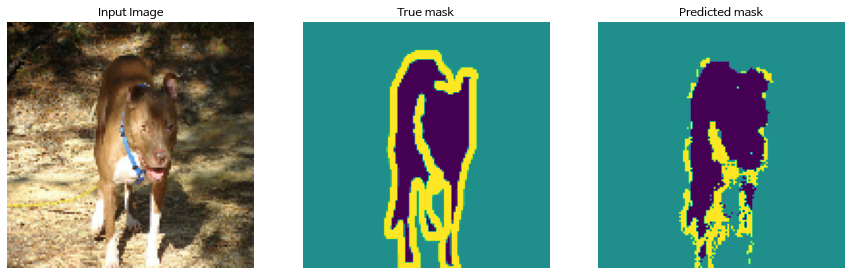

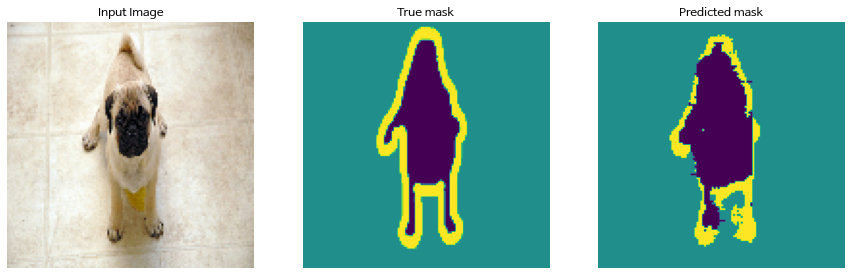

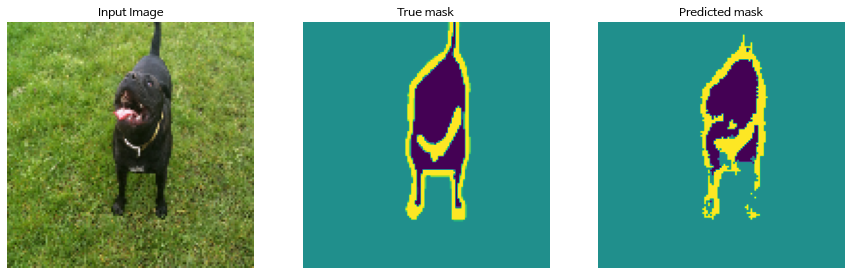

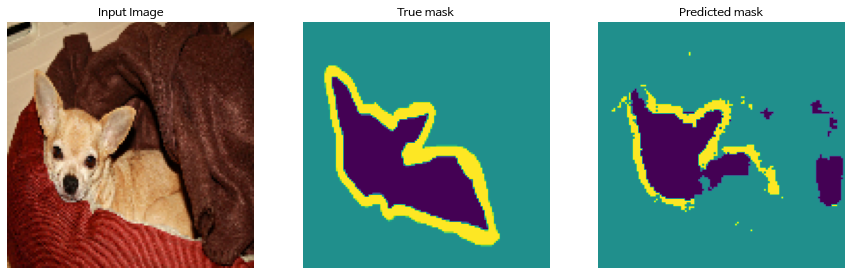

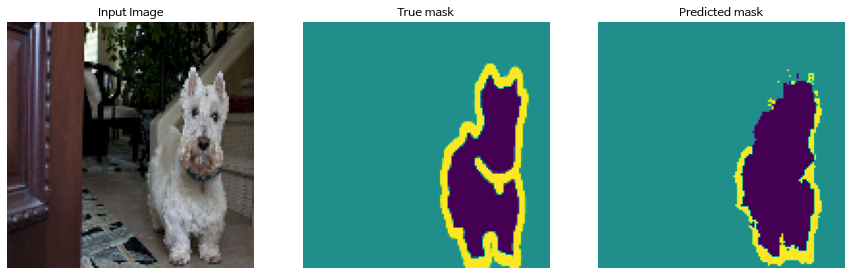

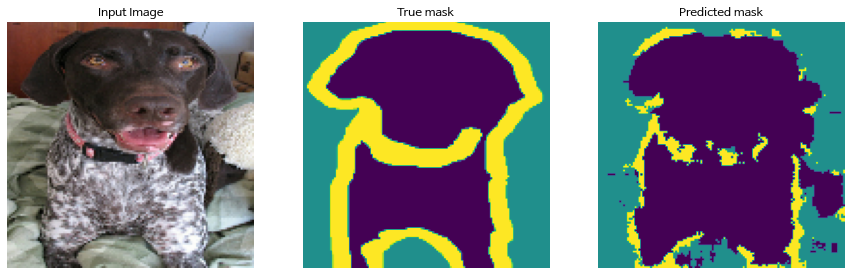

In [78]:
show_predictions(test_dataset, 10)